In [2]:
# importing of modules for CIFAR-10 CNN 
from tensorflow.keras.datasets import cifar100
import tensorflow.keras.applications as apps
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf
# importing of service libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# Learning rate (0.0001, 0.1, 0.5), dropout rate (0, 0.4, 0.8), architecture (alexNet, vggNet, resnet), optimisers (sgd, adam, rmsprop), data aug
learningRates = [0.005, 0.015, 0.075]
dropoutRates = [0.1, 0.5, 0.75]
print('Libraries imported.')
tf._logging.disable()
optimisers = [tf.keras.optimizers.SGD(), tf.keras.optimizers.RMSprop(), tf.keras.optimizers.Adagrad()]
# mpl.rcParams['figure.dpi'] = 100


2024-04-24 16:43:20.683033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 16:43:20.923830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 16:43:20.923859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 16:43:20.970518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 16:43:21.059749: I tensorflow/core/platform/cpu_feature_guar

Libraries imported.


2024-04-24 16:43:23.596047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 16:43:23.708466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 16:43:23.708505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 16:43:23.710859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 16:43:23.710886: I external/local_xla/xla/stream_executor

The following constant and variable definitions are needed for the network and training parameters.


In [3]:
#training constants
BATCH_SIZE = 100
N_EPOCH = 100 # use 20 for best initial results
N_CLASSES = 100
VERBOSE = 1
VALIDATION_SPLIT = 0.2
def showModelStats(modelFilename, historyFilename):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    fig.tight_layout()
    model = tf.keras.saving.load_model(modelFilename)
    history = np.load(historyFilename, allow_pickle='TRUE').item()
    global input_X_test, output_Y_test
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])

    # list all data in history
    print(history.keys())
    plt.subplot(1, 2, 1)
    # summarize history for accuracy
    #plt.plot(mo)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    print(np.argmin(history["val_loss"]))
    plt.subplot(1, 2, 2)
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
print('Main variables initialised.')

Main variables initialised.


Constant definition for the training set images

In [4]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')

Image variables initialisation


__CIFAR-10 data loading and processing__

Loading and preparation of the CIFAR-10 training set.

In [5]:
#load dataset
(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data()
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')
 
# convert to categorical
output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES) 
# idx = np.random.permutation(len(input_X_train))
# input_X_train, output_Y_train = input_X_train[idx], output_Y_train[idx]
# # float and normalization
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**Visualisation of two sample CIFAR-10 images**

Here we will visualise two sample images from the dataset.

In [16]:
vgg = apps.VGG16(classes=N_CLASSES, weights=None, include_top=False, pooling="max", input_shape=input_X_train[0].shape)
flatten = Flatten()(vgg.layers[-2].output)
dense1 = Dense(2048, activation="relu")(flatten)
dense2 = Dense(2048, activation="relu")(dense1)
predictions = Dense(N_CLASSES, activation="softmax", name="predictions")(dense2)
model = tf.keras.Model(inputs=vgg.inputs, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

**Training of the CNN**

This line of code trains the model, saving the results in the history variable.



In [17]:
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=25, start_from_epoch=10, restore_best_weights=True)

In [7]:
# training/fitting of the DNN model
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
# history = model.fit(train_datagen.flow(input_X_train[0:round(len(input_X_train)*(1 - VALIDATION_SPLIT))], 
#                                        output_Y_train[0:round(len(output_Y_train)*(1 - VALIDATION_SPLIT))], 
#                                        batch_size=Bn  ATCH_SIZE), 
#                                        validation_data=train_datagen.flow(
#                                            input_X_train[round(len(input_X_train)*(1 - VALIDATION_SPLIT)):len(input_X_train)],
#                                            output_Y_train[round(len(output_Y_train)*(1 - VALIDATION_SPLIT)):len(output_Y_train)], 
#                                            batch_size=BATCH_SIZE

#                                        ), epochs=N_EPOCH,  verbose=VERBOSE, callbacks=[es])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE, callbacks=[es])
model.save("vgg_def.keras")
np.save("vgg_def_history.npy", history.history)

Epoch 1/100


2024-04-22 21:12:49.902785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-22 21:12:50.040455: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 21:12:50.568868: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 21:12:50.640082: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f72896a2780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 21:12:50.640110: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
I0000 00:00:1713816770.686094  198020 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 11s 17ms/step - loss: 4.6052 - accuracy: 0.0100 - val_loss: 4.6053 - val_accuracy: 0.0085
Epoch 2/100
400/400 [==============================] - 7s 16ms/step - loss: 4.6052 - accuracy: 0.0106 - val_loss: 4.6054 - val_accuracy: 0.0077
Epoch 3/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6051 - accuracy: 0.0104 - val_loss: 4.6055 - val_accuracy: 0.0077
Epoch 4/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6051 - accuracy: 0.0103 - val_loss: 4.6056 - val_accuracy: 0.0077
Epoch 5/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6050 - accuracy: 0.0105 - val_loss: 4.6058 - val_accuracy: 0.0077
Epoch 6/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6050 - accuracy: 0.0106 - val_loss: 4.6059 - val_accuracy: 0.0077
Epoch 7/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6050 - accuracy: 0.0108 - val_loss: 4.6060 - val_accuracy: 0.0077
Epo

100/100 [==============================] - 1s 6ms/step - loss: 8.0251 - accuracy: 0.2203

Test score/loss: 8.02513313293457
Test accuracy: 0.22030000388622284
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


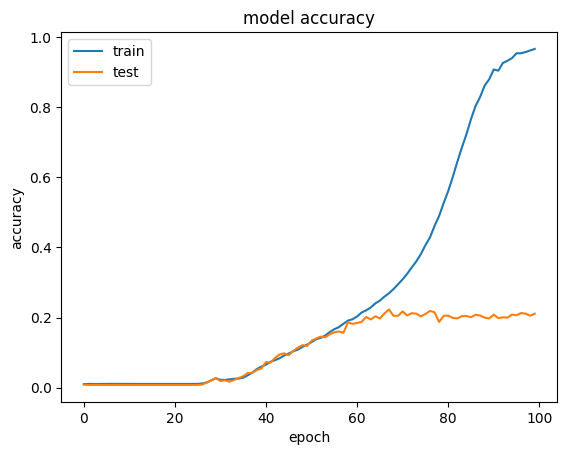

67


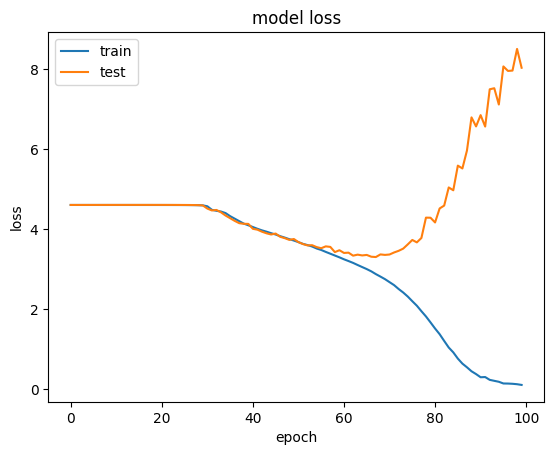

In [8]:
showModelStats("vgg_def.keras", "vgg_def_history.npy")

In [18]:
def createNewAlexNet(dropoutRate):
    inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
    conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
    conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
    conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
    conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
    conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
    flatten = tf.keras.layers.Flatten()(pool3)
    dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
    dropout1 = tf.keras.layers.Dropout(dropoutRate)(dense1)
    dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(dropoutRate)(dense2)
    predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
    model = tf.keras.Model(inputs=inp, outputs=predictions)
    return model

model = createNewAlexNet(0)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
model.save(f"alexNet_def.keras")
np.save(f"alexNet_def_history.npy", history.history)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 212)       3207

2024-04-24 00:28:02.285421: I external/local_xla/xla/service/service.cc:168] XLA service 0x5628e3dd7720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 00:28:02.285466: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
I0000 00:00:1713914882.362824   30272 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 8s 16ms/step - loss: 4.5500 - accuracy: 0.0203 - val_loss: 4.4399 - val_accuracy: 0.0311
Epoch 2/100
400/400 [==============================] - 6s 15ms/step - loss: 4.2407 - accuracy: 0.0442 - val_loss: 4.1185 - val_accuracy: 0.0665
Epoch 3/100
400/400 [==============================] - 6s 15ms/step - loss: 4.0242 - accuracy: 0.0830 - val_loss: 3.9109 - val_accuracy: 0.1130
Epoch 4/100
400/400 [==============================] - 6s 15ms/step - loss: 3.8081 - accuracy: 0.1209 - val_loss: 3.6640 - val_accuracy: 0.1516
Epoch 5/100
400/400 [==============================] - 6s 16ms/step - loss: 3.6121 - accuracy: 0.1535 - val_loss: 3.5580 - val_accuracy: 0.1665
Epoch 6/100
400/400 [==============================] - 6s 15ms/step - loss: 3.4449 - accuracy: 0.1811 - val_loss: 3.5022 - val_accuracy: 0.1790
Epoch 7/100
400/400 [==============================] - 6s 15ms/step - loss: 3.2868 - accuracy: 0.2123 - val_loss: 3.4590 - val_accuracy: 0.1836
Epoc

100/100 [==============================] - 1s 5ms/step - loss: 2.8744 - accuracy: 0.3031

Test score/loss: 2.874448776245117
Test accuracy: 0.30309998989105225
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


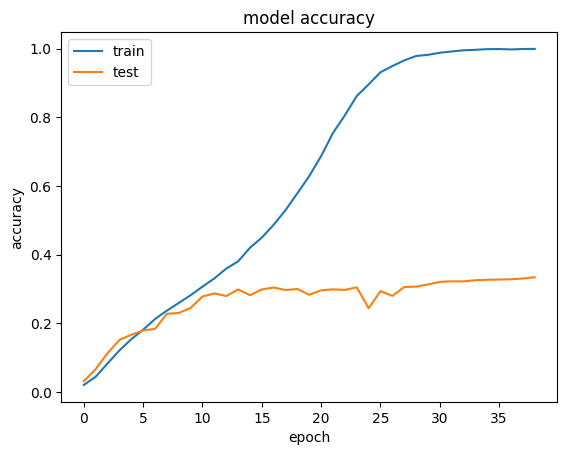

13


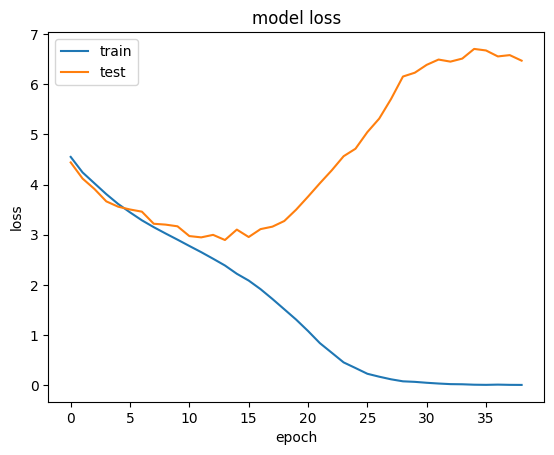

In [19]:
showModelStats("alexNet_def.keras", "alexNet_def_history.npy")

In [11]:

for i in range(0, len(dropoutRates)):
    p = dropoutRates[i]
    model = createNewAlexNet(p)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
    
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_dropout_{p}.keras")
    np.save(f"alexNet_dropout_{p}_history.npy", history.history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 82)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 212)       3207

NameError: name 'es' is not defined

100/100 [==============================] - 1s 5ms/step - loss: 3.3274 - accuracy: 0.3264

Test score/loss: 3.3274195194244385
Test accuracy: 0.3264000117778778
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


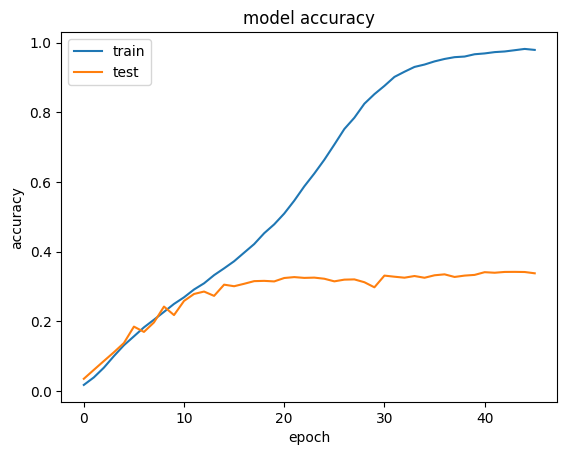

16


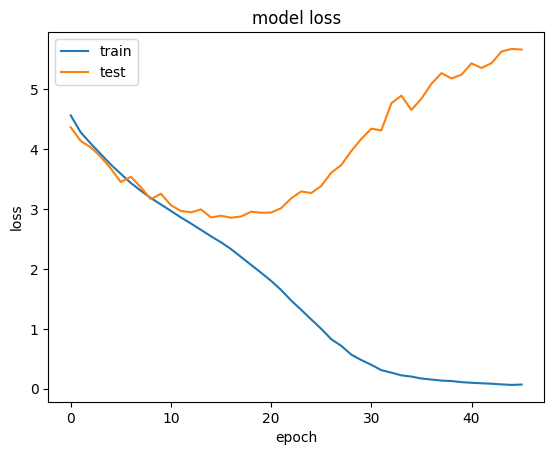

100/100 [==============================] - 1s 5ms/step - loss: 2.3318 - accuracy: 0.4165

Test score/loss: 2.331845998764038
Test accuracy: 0.4165000021457672
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


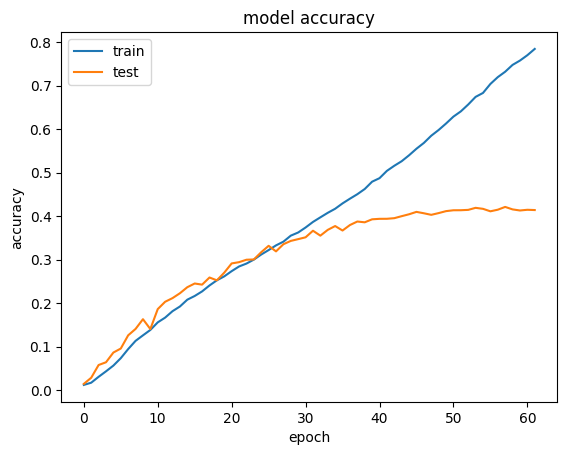

41


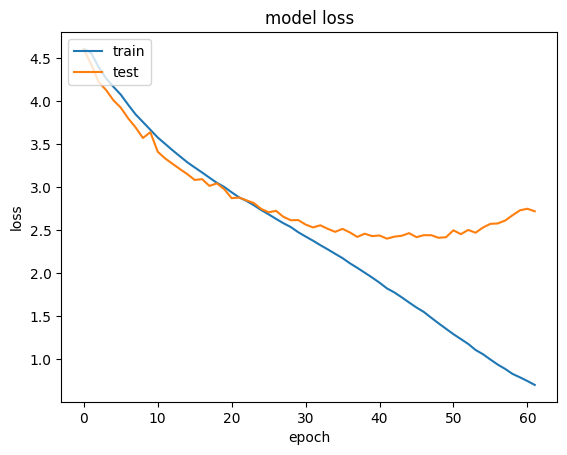

100/100 [==============================] - 1s 5ms/step - loss: 2.7223 - accuracy: 0.4314

Test score/loss: 2.722290277481079
Test accuracy: 0.43140000104904175
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


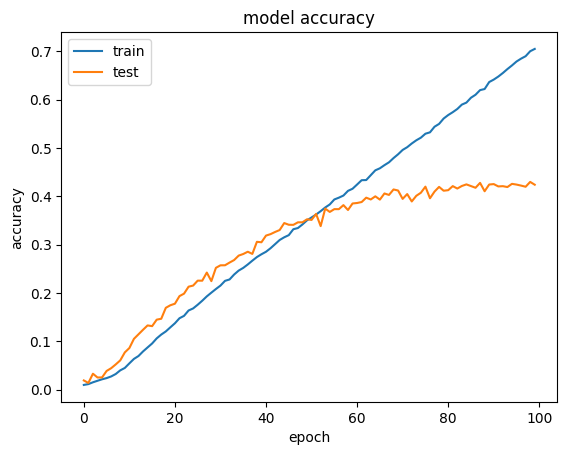

68


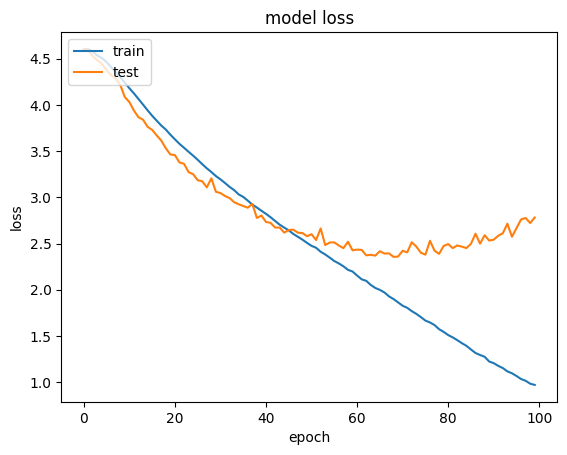

In [10]:
for i in range(0, len(dropoutRates)):
    p = dropoutRates[i]
    showModelStats(f"alexNet_dropout_{p}.keras", f"alexNet_dropout_{p}_history.npy")

In [10]:
optimisers = [tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adagrad]
for i in range(0, len(optimisers)):
    model = createNewAlexNet(dropoutRates[1])
    model.summary()
    optimizer = optimisers[i]()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_optim_{i}_def.keras")
    np.save(f"alexNet_optim_{i}_history.npy", history.history)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 2.3409 - accuracy: 0.4092

Test score/loss: 2.3408923149108887
Test accuracy: 0.4092000126838684
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
40


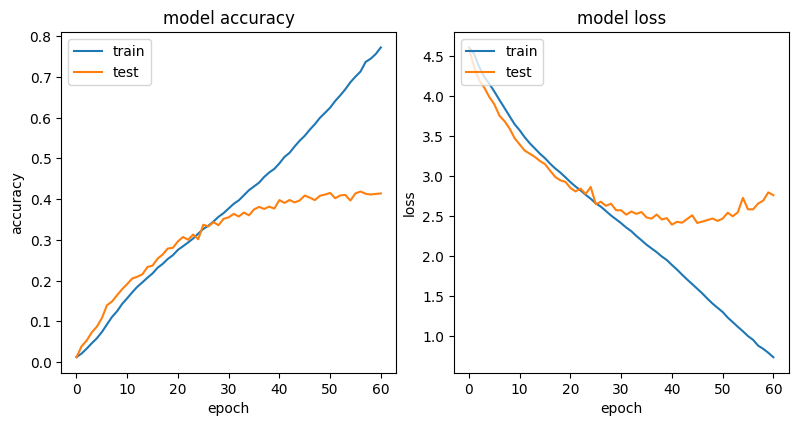

100/100 [==============================] - 1s 5ms/step - loss: 3.0346 - accuracy: 0.2947

Test score/loss: 3.03462290763855
Test accuracy: 0.2946999967098236
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
18


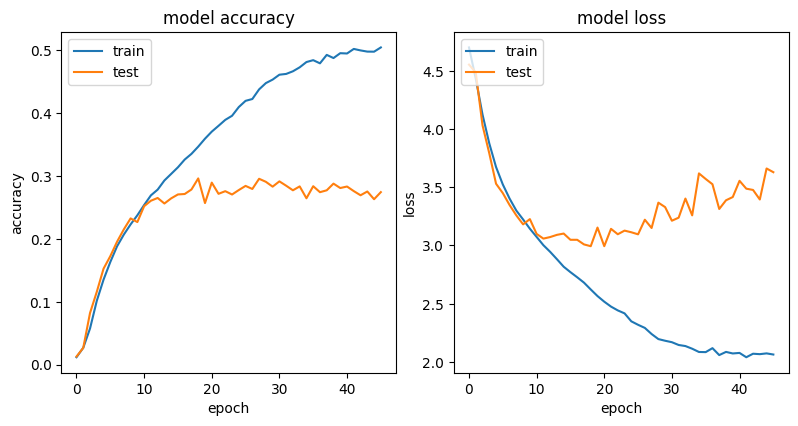

100/100 [==============================] - 1s 5ms/step - loss: 2.5880 - accuracy: 0.3583

Test score/loss: 2.5880212783813477
Test accuracy: 0.35830000042915344
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
99


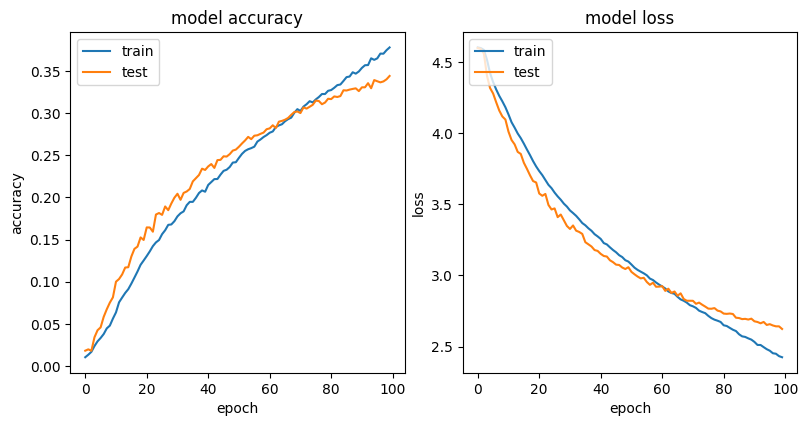

In [40]:
for i in range(0, len(optimisers)):
    showModelStats(f"alexNet_optim_{i}_def.keras", f"alexNet_optim_{i}_history.npy")

In [26]:

for i in range(0, len(learningRates)):
    lr = learningRates[i]
    model = createNewAlexNet(dropoutRates[0])
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr), metrics=['accuracy'])
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_lr_{lr}_def.keras")
    np.save(f"alexNet_lr_{lr}_history.npy", history.history)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 82)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 2.7116 - accuracy: 0.4338

Test score/loss: 2.711552381515503
Test accuracy: 0.43380001187324524
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


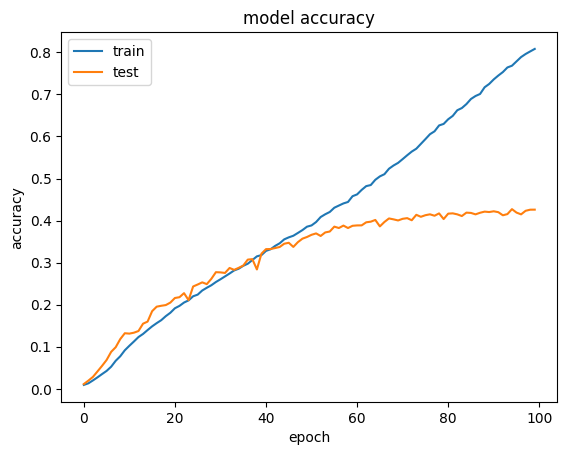

71


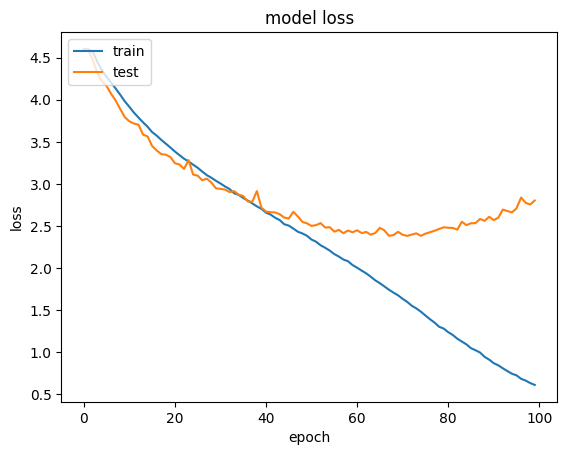

100/100 [==============================] - 1s 5ms/step - loss: 2.3197 - accuracy: 0.4293

Test score/loss: 2.3197150230407715
Test accuracy: 0.4293000102043152
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


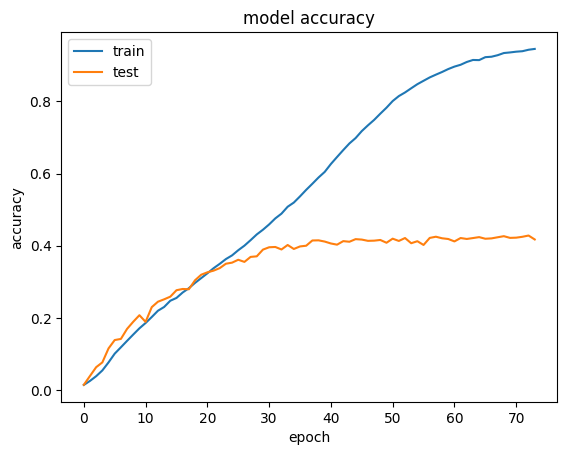

38


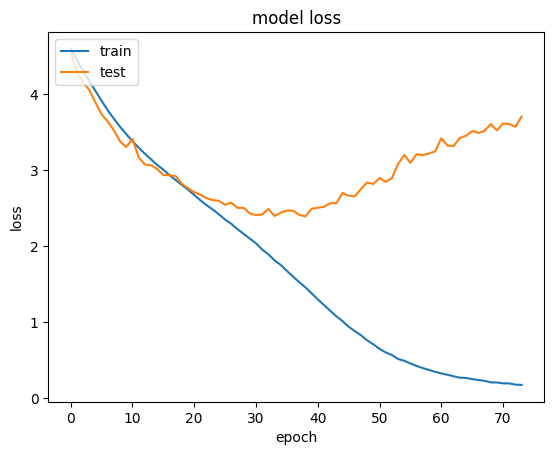

100/100 [==============================] - 1s 5ms/step - loss: 2.5750 - accuracy: 0.3639

Test score/loss: 2.574968099594116
Test accuracy: 0.36390000581741333
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


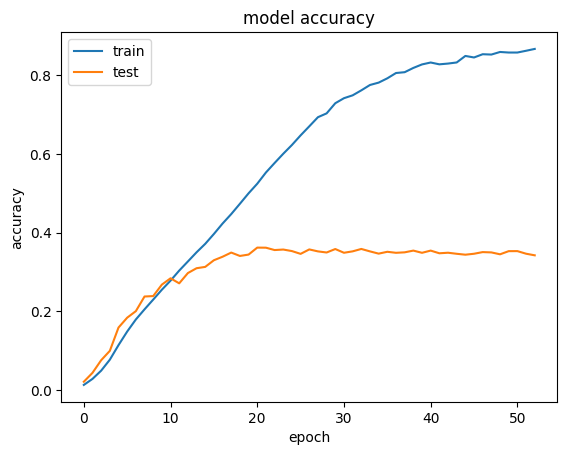

17


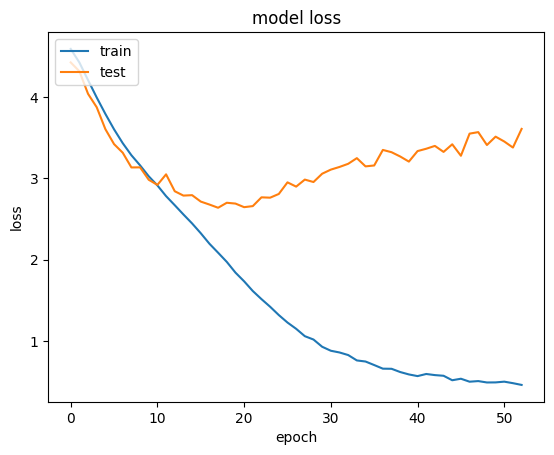

In [21]:
for i in range(0, len(learningRates)):
    lr = learningRates[i]
    showModelStats(f"alexNet_lr_{lr}_def.keras", f"alexNet_lr_{lr}_history.npy")

In [7]:
for i in range(0, len(learningRates)):
    lr = learningRates[i]
    model = createNewAlexNet(dropoutRates[1])
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True), metrics=['accuracy'])
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_lr_{lr}_momentum_def.keras")
    np.save(f"alexNet_lr_{lr}_momentum_history.npy", history.history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 82)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 212)       3207

2024-04-23 19:50:10.248794: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-23 19:50:10.570423: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 19:50:10.819297: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 19:50:11.180470: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1b9fa93310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 19:50:11.180505: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
I0000 00:00:1713898211.206797   58831 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 9s 16ms/step - loss: 4.5285 - accuracy: 0.0176 - val_loss: 4.3247 - val_accuracy: 0.0314
Epoch 2/100
400/400 [==============================] - 6s 15ms/step - loss: 4.2083 - accuracy: 0.0484 - val_loss: 3.9388 - val_accuracy: 0.0896
Epoch 3/100
400/400 [==============================] - 6s 15ms/step - loss: 3.8960 - accuracy: 0.0955 - val_loss: 3.6224 - val_accuracy: 0.1410
Epoch 4/100
400/400 [==============================] - 6s 15ms/step - loss: 3.6359 - accuracy: 0.1350 - val_loss: 3.4333 - val_accuracy: 0.1791
Epoch 5/100
400/400 [==============================] - 6s 15ms/step - loss: 3.4148 - accuracy: 0.1759 - val_loss: 3.2445 - val_accuracy: 0.2122
Epoch 6/100
400/400 [==============================] - 6s 15ms/step - loss: 3.2214 - accuracy: 0.2134 - val_loss: 3.0472 - val_accuracy: 0.2532
Epoch 7/100
400/400 [==============================] - 6s 15ms/step - loss: 3.0634 - accuracy: 0.2426 - val_loss: 2.9394 - val_accuracy: 0.2709
Epoc

100/100 [==============================] - 1s 5ms/step - loss: 2.2643 - accuracy: 0.4195

Test score/loss: 2.264295816421509
Test accuracy: 0.4194999933242798
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


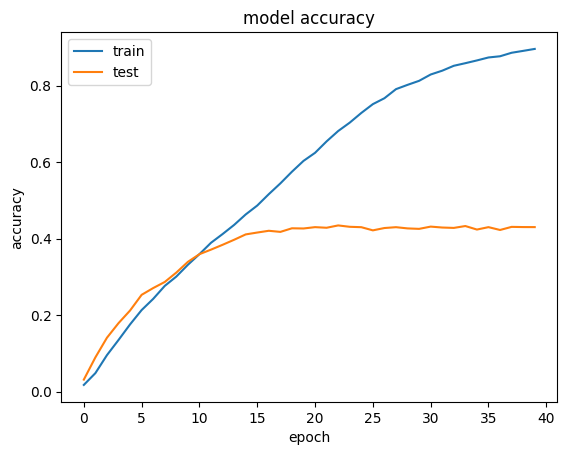

14


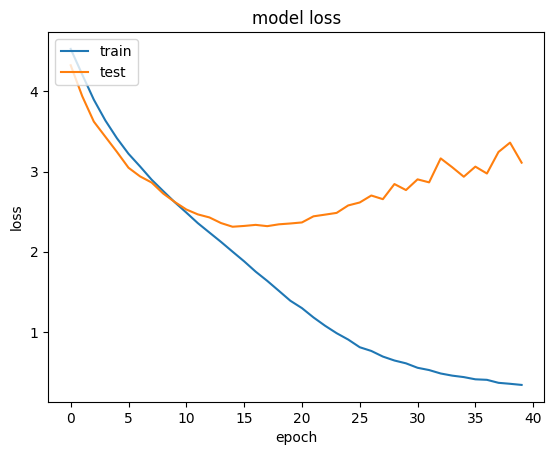

100/100 [==============================] - 1s 5ms/step - loss: 2.5540 - accuracy: 0.3690

Test score/loss: 2.5540361404418945
Test accuracy: 0.36899998784065247
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


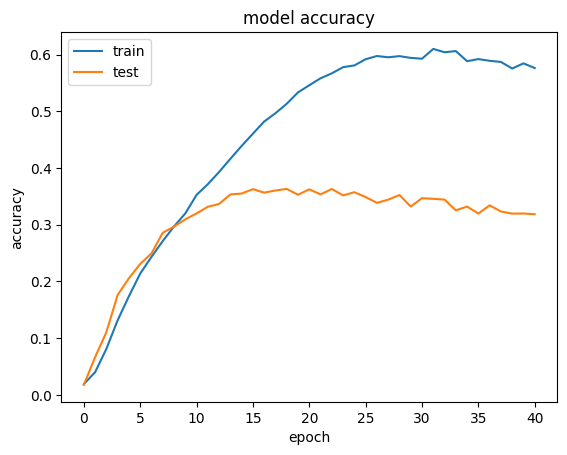

15


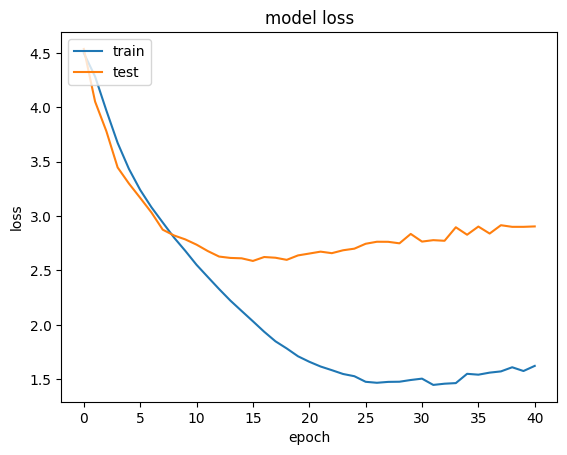

100/100 [==============================] - 1s 5ms/step - loss: 4.6059 - accuracy: 0.0100

Test score/loss: 4.6059041023254395
Test accuracy: 0.009999999776482582
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


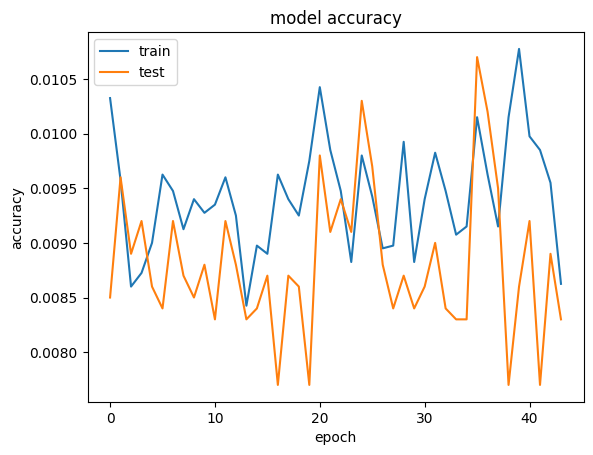

8


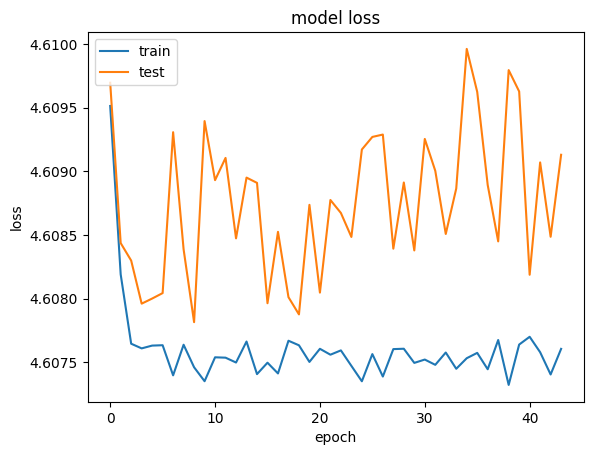

In [22]:
for lr in learningRates:
    showModelStats(f"alexNet_lr_{lr}_momentum_def.keras", f"alexNet_lr_{lr}_momentum_history.npy")

In [24]:
lr = learningRates[0]
model = createNewAlexNet(dropoutRates[1])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.0005), metrics=['accuracy'])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
model.save(f"alexNet_weight_decay_def.keras")
np.save(f"alexNet_weight_decay_history.npy", history.history)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 2.2670 - accuracy: 0.4243

Test score/loss: 2.2670183181762695
Test accuracy: 0.4242999851703644
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


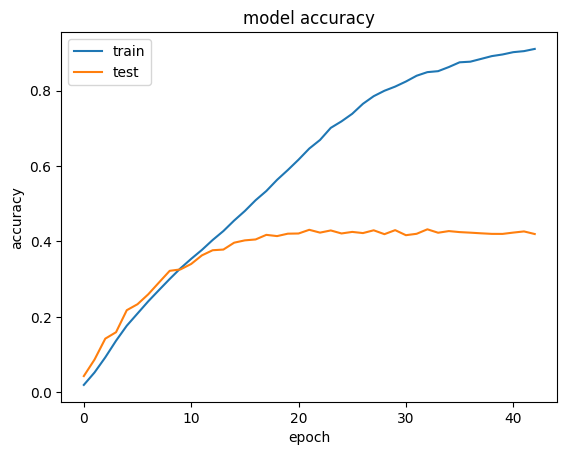

17


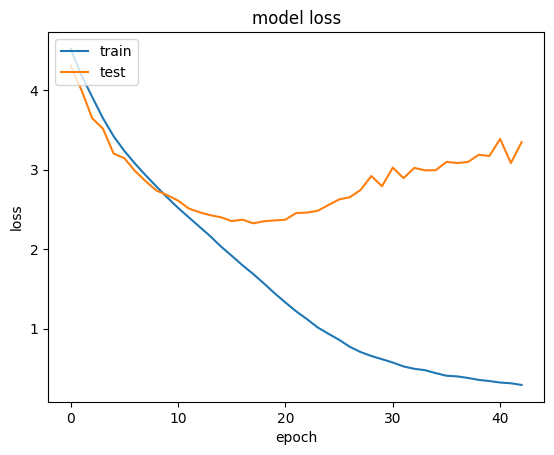

In [25]:

showModelStats(f"alexNet_weight_decay_def.keras", f"alexNet_weight_decay_history.npy")

In [28]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
   width_shift_range=0.15,
   height_shift_range=0.15,
   zoom_range=0.15,
   horizontal_flip=True,
   fill_mode='nearest')

#fit the dataset
lr = learningRates[0]
model = createNewAlexNet(dropoutRates[1])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.0005), metrics=['accuracy'])
idx = np.random.permutation(len(input_X_train))
input_X_train = input_X_train[idx]
output_Y_train = output_Y_train[idx]
validationData = (input_X_train[round(len(input_X_train) * (1 - VALIDATION_SPLIT)):len(input_X_train)], output_Y_train[round(len(output_Y_train) * (1 - VALIDATION_SPLIT)):len(output_Y_train)])
datagen.fit(input_X_train[0:round(len(input_X_train) * (1 - VALIDATION_SPLIT))], rounds=2)
history = model.fit(datagen.flow(input_X_train[0:round(len(input_X_train) * (1 - VALIDATION_SPLIT))], 
                                 output_Y_train[0:round(len(output_Y_train) * (1 - VALIDATION_SPLIT))], 
                                 batch_size=BATCH_SIZE), steps_per_epoch=round(len(input_X_train) * (1 - VALIDATION_SPLIT)) // BATCH_SIZE, validation_data=validationData, epochs=N_EPOCH, verbose=1, callbacks=[es])
model.save(f"alexNet_augmented.keras")
np.save(f"alexNet_augmented_history.npy", history.history)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 82)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 1.8461 - accuracy: 0.5214

Test score/loss: 1.846123456954956
Test accuracy: 0.521399974822998
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
59


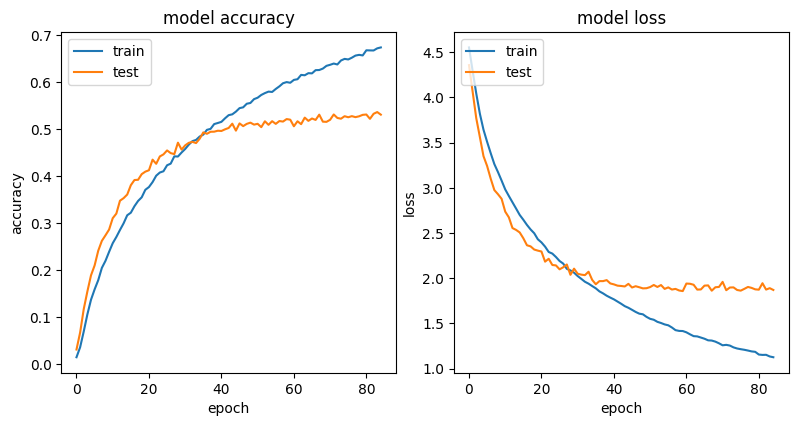

In [39]:
showModelStats(f"alexNet_augmented.keras", "alexNet_augmented_history.npy")

In [22]:
resNet = apps.ResNet50V2(classes=N_CLASSES, weights=None, include_top=False, pooling="max", input_shape=input_X_train[0].shape)
avgPool = tf.keras.layers.GlobalAveragePooling2D()(resNet.layers[-2].output)
flatten = Flatten()(avgPool)
predictions = Dense(N_CLASSES, activation="softmax", name="predictions")(flatten)
print(len(resNet.layers))
model = tf.keras.Model(inputs=resNet.inputs, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

191
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                        

In [23]:
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE, callbacks=[es])
model.save("resNet_def.keras")
np.save("resNet_def_history.npy", history.history)

Epoch 1/100
400/400 [==============================] - 19s 31ms/step - loss: 4.3015 - accuracy: 0.0595 - val_loss: 4.0225 - val_accuracy: 0.0884
Epoch 2/100
400/400 [==============================] - 12s 30ms/step - loss: 3.7962 - accuracy: 0.1230 - val_loss: 3.7662 - val_accuracy: 0.1313
Epoch 3/100
400/400 [==============================] - 12s 30ms/step - loss: 3.5233 - accuracy: 0.1666 - val_loss: 3.6267 - val_accuracy: 0.1534
Epoch 4/100
400/400 [==============================] - 12s 29ms/step - loss: 3.3042 - accuracy: 0.2040 - val_loss: 3.5087 - val_accuracy: 0.1692
Epoch 5/100
400/400 [==============================] - 11s 26ms/step - loss: 3.1046 - accuracy: 0.2418 - val_loss: 3.3858 - val_accuracy: 0.1966
Epoch 6/100
400/400 [==============================] - 13s 32ms/step - loss: 2.9237 - accuracy: 0.2784 - val_loss: 3.3198 - val_accuracy: 0.2085
Epoch 7/100
400/400 [==============================] - 12s 31ms/step - loss: 2.7424 - accuracy: 0.3133 - val_loss: 3.2942 - val_ac

2024-04-24 16:43:54.326366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-24 16:43:54.513482: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100/100 [==============================] - 2s 7ms/step - loss: 3.2048 - accuracy: 0.2495

Test score/loss: 3.204841375350952
Test accuracy: 0.24950000643730164
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10


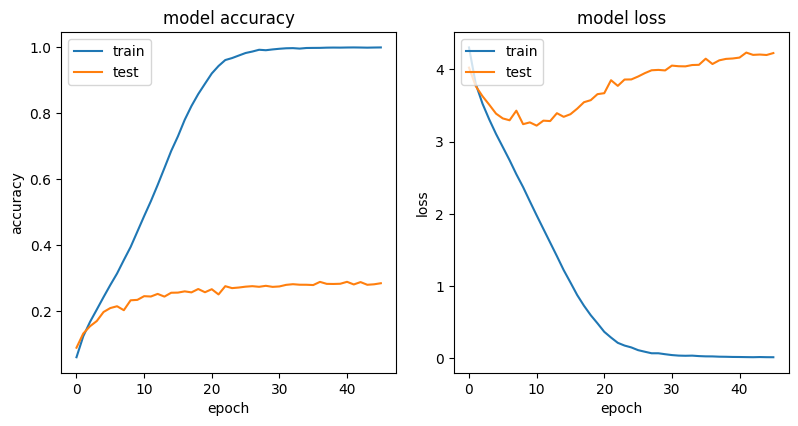

In [6]:
showModelStats("resNet_def.keras", "resNet_def_history.npy")